In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from portfolio import portfolio
from predictor import stockprediction

In [2]:
stocks = [
 'AAPL', 'AMZN', 'GOOG', 'MSFT', 'YHOO'
]

# data frame to hold real and predicted data - we use the training set for this
df = pd.DataFrame()
riskdf = pd.DataFrame()
retdf = pd.DataFrame()  # estimated return
rretdf = pd.DataFrame() # real return

# time window for estimated risk
lookback = 24*5

# get the real data and the predicted data
for s in stocks:
    p = stockprediction(s, alldata=False)
    p.searchbest(0)
    
    [ypred, score, corr] = p.query(p.xtrain, p.ytrain)
    df[s + 'x'] = p.xtrain['Adj_Close']
    df[s + 'y'] = p.ytrain
    df[s + 'yp'] = ypred
    
    # add the risk and estimated return variables (6 months lookback period)
    riskdf[s] = p.xtrain['Adj_Close'].rolling(lookback).std()
    retdf[s] = ypred - p.ytrain.shift(1)
    rretdf[s] = p.ytrain - p.ytrain.shift(1)


AAPL - data found locally
parameters found: {'kernel': 'linear', 'C': 5}
AMZN - data found locally
parameters found: {'kernel': 'linear', 'C': 1.5}
GOOG - data found locally
parameters found: {'kernel': 'linear', 'C': 0.5}
MSFT - data found locally
parameters found: {'kernel': 'linear', 'C': 2}
YHOO - data found locally
parameters found: {'kernel': 'linear', 'C': 0.5}


In [3]:
# compute the profit
profit = 0
ptime = []

# initial set of weights
w0 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# do back testing portfolio management 
for i in range(lookback+5, p.xtrain.shape[0]-1):
    
    # compute the correlation matrix looking at data for the last six months
    m = np.eye(5)
    for k1 in range(0, 4):
        for k2 in range(k1+1, 5):
            s1 = df[stocks[k1] + 'x'].iloc[i-lookback:i]
            s2 = df[stocks[k2] + 'x'].iloc[i-lookback:i]
            m[k1, k2] = np.corrcoef(s1, s2)[0, 1]
            m[k2, k1] = m[k1, k2]
    
    # get needed variables
    retv = retdf.iloc[i]
    riskv = riskdf.iloc[i]
    
    # define a portfolio
    port = portfolio(retv, riskv, m)
    
    # get the sharpe weights
    w = np.array(port.sharpe())
    
    # update profit
    profit = profit + np.dot((w - w0), rretdf.iloc[i+1])
    ptime.append(profit)

allocation of portfolio: [  1.20718497e-16   1.65658573e-16   2.16201411e-16   9.43256619e-01
   5.67433813e-02]


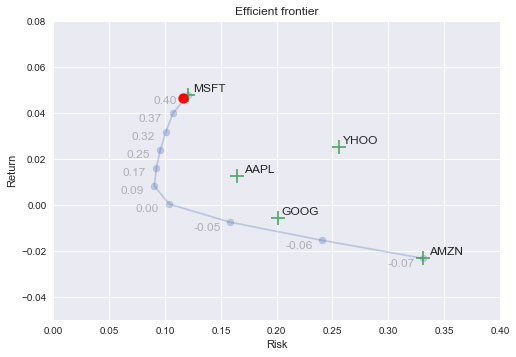

profit:  0.591400014452


In [4]:
print "allocation of portfolio:", port.sharpe()    
port.plotfrontier(xlim=[0, 0.4], ylim=[-0.05, 0.08], stocknames=stocks)
print "profit: ", profit

SPY - data found locally


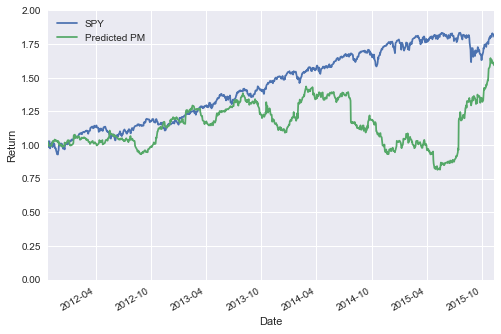

In [5]:
# preprocessing data to be able to plot against SPY
p = stockprediction('SPY', alldata=False)
spy = p.xtrain['Adj_Close'][lookback+5:-1]
ptime = np.array(ptime)
# normalize
ptime = ptime + 1

spy.plot(label='SPY')
plt.plot(spy.index, ptime, label='Predicted PM')
plt.ylabel('Return')
plt.legend()
plt.ylim([0, 2])
plt.show()